# Especificações filtro

- $A_p = 0,5$ dB
- $A_r = 65$ dB
- $\Omega_{p1} = 850$ rad/s
- $\Omega_{r1} = 980$ rad/s
- $\Omega_{r2} = 1020$ rad/s
- $\Omega_{p2} = 1150$ rad/s
- $\Omega_{s} = 10000$ rad/s

In [1]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt
from scipy import signal

#################################################################
# ESPECIFICAÇÕES DO FILTRO
Ap = .5 # dB
Ar = 65 # dB
wp1a = 850 # rad/s
wr1a = 980 # rad/s
wr2a = 1020 # rad/s
wp2a = 1150 # rad/s
ws = 10000 # rad/s
T = 2*np.pi/ws # seg: período de amostragem
dp = 1 - 10**(-Ap/20)
dr = 10**(-Ar/20)

#################################################################
# PASSO 1: frequências no tempo discreto
wp1 = wp1a*2*np.pi/ws # rad/amostra
wr1 = wr1a*2*np.pi/ws # rad/amostra
wr2 = wr2a*2*np.pi/ws # rad/amostra
wp2 = wp2a*2*np.pi/ws # rad/amostra
print("Frequências em tempo discreto:")
print("%.2f;\t %.2f;\t %.2f;\t %.2f [rad/amostra]\n"%(wp1, wr1, wr2, wp2))

#################################################################
# PASSO 2: frequências analógicas pré-distorcidas
wp1_ad = (2/T)*np.tan(wp1/2)
wr1_ad = (2/T)*np.tan(wr1/2)
wr2_ad = (2/T)*np.tan(wr2/2)
wp2_ad = (2/T)*np.tan(wp2/2)
print("Frequências analógicas pré-distorcidas:")
print("%.2f;\t %.2f;\t %.2f;\t %.2f [rad/s]"%(wp1, wr1, wr2, wp2));

Frequências em tempo discreto:
0.53;	 0.62;	 0.64;	 0.72 [rad/amostra]

Frequências analógicas pré-distorcidas:
0.53;	 0.62;	 0.64;	 0.72 [rad/s]


### Projeto do filtro analógico correspondente

Ordem dos filtros: 5 4 4 3


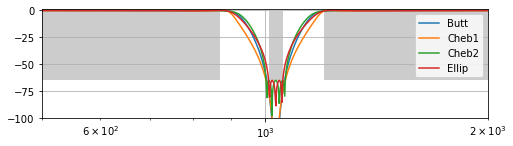

In [2]:
#################################################################
# PASSO 3: projeto do filtro analógico correspondente
N1, wn1 = signal.buttord(wp=[wp1_ad, wp2_ad], ws=[wr1_ad, wr2_ad], gpass=Ap, gstop=Ar, analog=True) #Butterworth
N2, wn2 = signal.cheb1ord(wp=[wp1_ad, wp2_ad], ws=[wr1_ad, wr2_ad], gpass=Ap, gstop=Ar, analog=True) #Chebyshev I
N3, wn3 = signal.cheb2ord(wp=[wp1_ad, wp2_ad], ws=[wr1_ad, wr2_ad], gpass=Ap, gstop=Ar, analog=True) #Chebyshev  II
N4, wn4 = signal.ellipord(wp=[wp1_ad, wp2_ad], ws=[wr1_ad, wr2_ad], gpass=Ap, gstop=Ar, analog=True) #Eliptico

print("Ordem dos filtros:", N1, N2, N3, N4)

z1a, p1a, k1a = signal.butter(N=N1, Wn=wn1, btype="bs", analog=True, output="zpk") #Butterworth
z2a, p2a, k2a = signal.cheby1(N2, rp=Ap, Wn=wn2, btype="bs", analog=True, output="zpk") #Chebyshev I
z3a, p3a, k3a = signal.cheby2(N3, rs=Ar, Wn=wn3, btype="bs", analog=True, output="zpk") #Chebyshev II
z4a, p4a, k4a = signal.ellip(N4, rp=Ap, rs=Ar, Wn=wn4, btype="bs", analog=True, output="zpk") #Elliptic

sys1a = signal.lti(z1a, p1a, k1a)
sys2a = signal.lti(z2a, p2a, k2a)
sys3a = signal.lti(z3a, p3a, k3a)
sys4a = signal.lti(z4a, p4a, k4a)

w = np.logspace(2.5, 4, 2000)
w1, mag1, phase1 = sys1a.bode(w)
w2, mag2, phase2 = sys2a.bode(w)
w3, mag3, phase3 = sys3a.bode(w)
w4, mag4, phase4 = sys4a.bode(w)

%matplotlib inline

plt.figure(figsize=(8,2))
plt.semilogx(w1, mag1);
plt.semilogx(w2, mag2);
plt.semilogx(w3, mag3);
plt.semilogx(w4, mag4);
plt.fill([min(w), wp1_ad,  wp1_ad,  min(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([max(w), wp2_ad,  wp2_ad,  max(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([wr1_ad, wr2_ad,  wr2_ad,  wr1_ad], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda rejeição
plt.legend(("Butt","Cheb1","Cheb2","Ellip"))
plt.ylim((-100,1))
plt.xlim((5e2,2e3))
plt.grid(1);

### Transformação bilinear

In [3]:
#################################################################
# PASSO 4: transformação bilinear discreto -> contínuo
z1, p1, k1 = signal.bilinear_zpk(sys1a.zeros, sys1a.poles, sys1a.gain, ws/2/np.pi)
z2, p2, k2 = signal.bilinear_zpk(sys2a.zeros, sys2a.poles, sys2a.gain, ws/2/np.pi)
z3, p3, k3 = signal.bilinear_zpk(sys3a.zeros, sys3a.poles, sys3a.gain, ws/2/np.pi)
z4, p4, k4 = signal.bilinear_zpk(sys4a.zeros, sys4a.poles, sys4a.gain, ws/2/np.pi)

sys1 = signal.dlti(z1, p1, k1)
sys2 = signal.dlti(z2, p2, k2)
sys3 = signal.dlti(z3, p3, k3)
sys4 = signal.dlti(z4, p4, k4)

### Conferir o filtro obtido

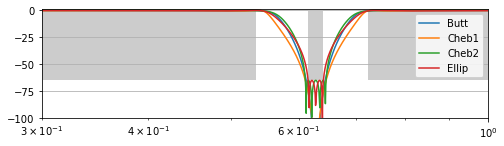

In [4]:
w = np.logspace(-1, 0, 2000)
w1, mag1, phase1 = signal.dbode(sys1, w)
w2, mag2, phase2 = signal.dbode(sys2, w)
w3, mag3, phase3 = signal.dbode(sys3, w)
w4, mag4, phase4 = signal.dbode(sys4, w)

# %matplotlib inline

plt.figure(figsize=(8,2))
plt.semilogx(w1, mag1);
plt.semilogx(w2, mag2);
plt.semilogx(w3, mag3);
plt.semilogx(w4, mag4);
plt.fill([min(w), wp1,  wp1,  min(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([max(w), wp2,  wp2,  max(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([wr1, wr2,  wr2,  wr1], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda rejeição
plt.legend(("Butt","Cheb1","Cheb2","Ellip"))
plt.ylim((-100,1))
plt.xlim((3e-1,1e0))
plt.grid(1);

# Outra forma de fazer (direto)

Ordem dos filtros: 5 4 4 3


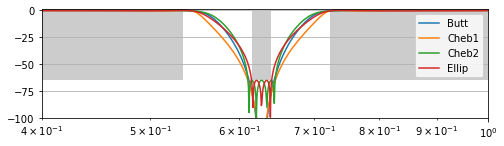

In [5]:
#################################################################
# PROJETO DO FILTRO DISCRETO
N1, wn1 = signal.buttord(wp=[wp1, wp2], ws=[wr1, wr2], gpass=Ap, gstop=Ar, analog=False, fs=2*np.pi) #Butterworth
N2, wn2 = signal.cheb1ord(wp=[wp1, wp2], ws=[wr1, wr2], gpass=Ap, gstop=Ar, analog=False, fs=2*np.pi) #Chebyshev I
N3, wn3 = signal.cheb2ord(wp=[wp1, wp2], ws=[wr1, wr2], gpass=Ap, gstop=Ar, analog=False, fs=2*np.pi) #Chebyshev  II
N4, wn4 = signal.ellipord(wp=[wp1, wp2], ws=[wr1, wr2], gpass=Ap, gstop=Ar, analog=False, fs=2*np.pi) #Eliptico

print("Ordem dos filtros:", N1, N2, N3, N4)

z1, p1, k1 = signal.butter(N1, Wn=wn1, btype="bs", analog=False, output="zpk", fs=2*np.pi) #Butterworth
z2, p2, k2 = signal.cheby1(N2, rp=Ap, Wn=wn2, btype="bs", analog=False, output="zpk", fs=2*np.pi) #Chebyshev I
z3, p3, k3 = signal.cheby2(N3, rs=Ar, Wn=wn3, btype="bs", analog=False, output="zpk", fs=2*np.pi) #Chebyshev II
z4, p4, k4 = signal.ellip(N4, rp=Ap, rs=Ar, Wn=wn4, btype="bs", analog=False, output="zpk", fs=2*np.pi) #Elliptic

sys1 = signal.dlti(z1, p1, k1)
sys2 = signal.dlti(z2, p2, k2)
sys3 = signal.dlti(z3, p3, k3)
sys4 = signal.dlti(z4, p4, k4)

w = np.logspace(-1, 0, 2000)
w1, mag1, phase1 = signal.dbode(sys1, w)
w2, mag2, phase2 = signal.dbode(sys2, w)
w3, mag3, phase3 = signal.dbode(sys3, w)
w4, mag4, phase4 = signal.dbode(sys4, w)

# %matplotlib inline

plt.figure(figsize=(8,2))
plt.semilogx(w1, mag1);
plt.semilogx(w2, mag2);
plt.semilogx(w3, mag3);
plt.semilogx(w4, mag4);
plt.fill([min(w), wp1,  wp1,  min(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([max(w), wp2,  wp2,  max(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([wr1, wr2,  wr2,  wr1], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda rejeição
plt.legend(("Butt","Cheb1","Cheb2","Ellip"))
plt.ylim((-100,1))
plt.xlim((4e-1,1e0))
plt.grid(1);

# Outra forma de fazer (usando `signal.iirdesign`)

In [20]:
#################################################################
# ESPECIFICAÇÕES DO FILTRO
Ap = .5 # dB
Ar = 65 # dB
wp1a = 850 # rad/s
wr1a = 980 # rad/s
wr2a = 1020 # rad/s
wp2a = 1150 # rad/s
ws = 10000 # rad/s
T = 2*np.pi/ws # seg: período de amostragem
dp = 1 - 10**(-Ap/20)
dr = 10**(-Ar/20)

#################################################################
# PROJETO

z1, p1, k1 = signal.iirdesign(wp=[wp1a, wp2a], ws=[wr1a, wr2a],
                              gpass=Ap, gstop=Ar, analog=False,
                              ftype='butter', output='zpk', fs=ws,)
z2, p2, k2 = signal.iirdesign(wp=[wp1a, wp2a], ws=[wr1a, wr2a],
                              gpass=Ap, gstop=Ar, analog=False,
                              ftype='cheby1', output='zpk', fs=ws,)
z3, p3, k3 = signal.iirdesign(wp=[wp1a, wp2a], ws=[wr1a, wr2a],
                              gpass=Ap, gstop=Ar, analog=False,
                              ftype='cheby2', output='zpk', fs=ws,)
z4, p4, k4 = signal.iirdesign(wp=[wp1a, wp2a], ws=[wr1a, wr2a],
                              gpass=Ap, gstop=Ar, analog=False,
                              ftype='ellip', output='zpk', fs=ws,)

#################################################################
# ANÁLISE DO FILTRO

sys1 = signal.dlti(z1, p1, k1)
sys2 = signal.dlti(z2, p2, k2)
sys3 = signal.dlti(z3, p3, k3)
sys4 = signal.dlti(z4, p4, k4)

w = np.logspace(-1, 0, 2000)
w1, mag1, phase1 = signal.dbode(sys1, w)
w2, mag2, phase2 = signal.dbode(sys2, w)
w3, mag3, phase3 = signal.dbode(sys3, w)
w4, mag4, phase4 = signal.dbode(sys4, w)

%matplotlib widget


# TRANFORMAÇÃO PARA CONFERIR AS FREQUÊNCIAS ANALÓGICAS!
w1, w2, w3, w4 = w1*ws/2/np.pi, w2*ws/2/np.pi, w3*ws/2/np.pi, w4*ws/2/np.pi

plt.figure(figsize=(8,2))
plt.semilogx(w1, mag1);
plt.semilogx(w2, mag2);
plt.semilogx(w3, mag3);
plt.semilogx(w4, mag4);

plt.fill([min(w1), wp1a,  wp1a,  min(w1)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([max(w1), wp2a,  wp2a,  max(w1)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([wr1a, wr2a,  wr2a,  wr1a], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda rejeição

plt.legend(("Butt","Cheb1","Cheb2","Ellip"))
plt.ylim((-100,1))
# plt.xlim((4e-1,1e0))
plt.grid(1)
plt.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …